In [4]:
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import numpy as np
from sklearn.model_selection import train_test_split

import librosa 
from librosa import feature
import soundfile
import os, glob, pickle
import re #split strings

from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')


emotions={ #german language
    'W':'anger',
    'L':'boredom',
    'E':'disgust',
    'A':'anxiety/fear',# *1
    'F':'happiness',# *0
    'T':'sadness',# *1
    'N':'neutral',# *0
}

# Not stressed: happy(2), calm(1).
# Stressed:     sad(3), fearful(5)
stress_emotions = {
    'F':0,
    'N':0,
    'A':1,
    'T':1
}
selected_emotions = {'F','N','A','T'}

In [5]:
#preprocesamiento de corpus
def preprocessing_data(filename):
    # 1) audio: mono 
    # 2) frecuencia de muestreo(SR): 16000Hz
    data, sr = librosa.load(filename, sr=16000, mono=True)
    #3) normalizacion
    X_scale = preprocessing.normalize([data])[0]
    #plot_data(normalizado, sr)
    #TODO: otros: farming, windowing, Voice Activity Detector (VAD), noise reduction,
    return [X_scale, sr]

In [6]:
def extract_features(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X_file_data = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X_file_data))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=60).T, axis=0)
            result = np.hstack((result, mfccs))
            
            mfccs_var = np.var(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=60).T, axis=0)
            result = np.hstack((result, mfccs_var)) 
            
            mfccs_std = np.std(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=60).T, axis=0)
            result = np.hstack((result, mfccs_std)) 
    
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X_file_data, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X_file_data), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [7]:

def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/media/yonel/730D-8298/DATASETS/Emo-DB/wav/*.wav"): #* PC
        file_name = os.path.basename(file) #            03-01-01-01-01-01-01.wav
        print('File:  %s' % (file_name), end='\r')
        file_name_no_type = file_name.split(".")[0] #   03-01-01-01-01-01-01
        #list_emotions = file_name_no_type.split("-") #  ['03', '01', '01', '01', '01', '01', '01']
        emotion = file_name_no_type[5]
        
        if emotion in selected_emotions:
            e = stress_emotions[emotion]
        
            feature = extract_features(file, chroma=True, mfcc=True, mel=True, contrast=True, tonnetz=True)
            x.append(feature)
            y.append(e)

    return np.array(x), np.array(y)

In [8]:
X_data,Y_data = load_data()
print("\n")
print("X_data:", X_data.shape, "Y_data:",  Y_data.shape)

File:  08a01Fd.wav

X_data: (281, 333) Y_data: (281,)


### Normalización de datos

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X_data)
Y = Y_data 
print("X_data:", X.shape, "Y_data:",  Y.shape)

X_data: (281, 333) Y_data: (281,)


### Reducción de dimensionalidad con PCA

In [12]:
from sklearn.decomposition import PCA
X =  PCA(n_components=250).fit_transform(X)
print("X_data:", X.shape, "Y_data:",  Y.shape)

X_data: (281, 250) Y_data: (281,)


No estresados: 150 | Estresados: 131


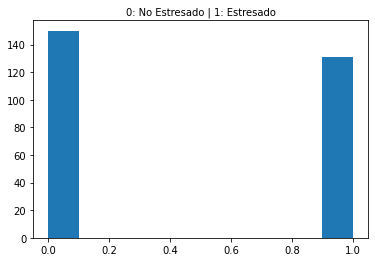

In [79]:
estresados = Y.sum()
no_estresados = Y.shape[0]-estresados
print("No estresados:",no_estresados, "| Estresados:", estresados)


import matplotlib.pyplot as plt

data = Y
plt.hist(data)
plt.title('0: No Estresado | 1: Estresado', fontsize=10)
#plt.savefig("Estres_NoEstres.png")
plt.show()

### división de datos: Entrenamiento, validación y prueba

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=10) 
print("Entrenamiento:", X_train.shape, Y_train.shape, "Prueba:", X_test.shape, Y_test.shape)

Entrenamiento: (196, 250) (196,) Prueba: (85, 250) (85,)


In [81]:
from keras import metrics
import math

model = Sequential([ 
    Dense(350, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(40, activation='relu'),
    Dense(2, activation="softmax")
])


initial_learning_rate = 0.01

def lr_exp_decay(epoch, lr):
    k = 0.05
    return initial_learning_rate * math.exp(-k*epoch)


opt = keras.optimizers.RMSprop(learning_rate=initial_learning_rate)


mts = keras.metrics.SparseCategoricalAccuracy(name="acc")
model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics= [mts])

In [82]:
from keras.callbacks import LearningRateScheduler

history = model.fit(X_train, Y_train, 
                    batch_size=20, 
                    epochs=50 , 
                    callbacks=[LearningRateScheduler(lr_exp_decay, verbose=1)])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
10/10 [==============================] - 0s 5ms/step - loss: 0.6614 - acc: 0.6533
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00951229424500714.
10/10 [==============================] - 0s 7ms/step - loss: 0.1261 - acc: 0.9622
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009048374180359595.
10/10 [==============================] - 0s 6ms/step - loss: 0.0092 - acc: 1.0000
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.008607079764250578.
10/10 [==============================] - 0s 6ms/step - loss: 0.0033 - acc: 1.0000
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.008187307530779819.
10/10 [==============================] - 0s 6ms/step - loss: 6.7044e-04 - acc: 1.0000
Epoch 6/50

Epoch 00006: LearningRateScheduler reducing learning rate to 0.007788007830714049.
10/10 [==========================

10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 47/50

Epoch 00047: LearningRateScheduler reducing learning rate to 0.001002588437228037.
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 48/50

Epoch 00048: LearningRateScheduler reducing learning rate to 0.0009536916221554962.
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 49/50

Epoch 00049: LearningRateScheduler reducing learning rate to 0.0009071795328941247.
10/10 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 50/50

Epoch 00050: LearningRateScheduler reducing learning rate to 0.0008629358649937049.
10/10 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - acc: 1.0000


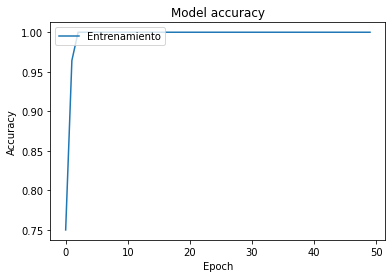

In [83]:
#plot precisión
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'validacion'], loc='upper left')
plt.show()

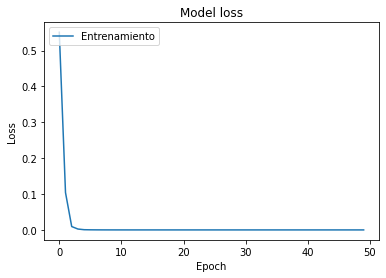

In [84]:
#plot perdida
plt.plot(history.history['loss']) 
#plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Entrenamiento', 'validacion'], loc='upper left') 
plt.show()

### Exactitud

In [85]:
from sklearn.metrics import classification_report
# precision, recall, score, accuracy
# print(model.evaluate(X_test,Y_test)[1]*100,"%") #[0] perdida, [1] presicion

y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        45
           1       0.92      0.90      0.91        40

    accuracy                           0.92        85
   macro avg       0.92      0.92      0.92        85
weighted avg       0.92      0.92      0.92        85



In [86]:
print(model.evaluate(X_test,Y_test)[1]*100,"%") #[0] perdida, [1] presicion

3/3 [==============================] - 0s 3ms/step - loss: 0.2711 - acc: 0.9176
91.76470637321472 %
